# PYNQ 201 - MNIST
----
This notebook will introduce you to the MNIST database and its accompanying MNIST Classifier model. The goal of this notebook is to: 
* understand what the MNIST database is,
* learn how to use the MNIST Classifier Model, 
* program the grove <span style="color:red">R</span><span style="color:green">G</span><span style="color:blue">B</span> LED stick, and
* explore how we can use the MNIST database and model in different ways! 

### What is the MNIST Database❓ ###
MNIST stands for the "Modified National Institute of Standards and Technology" database. It can be said that this database is the "Hello World!" implementation to machine learning, since it is a great starting point for people interested in learning about image classification and pattern recognition. 

The MNIST Database consists of 70,000 small, square 28x28 pixel grayscale images of handwritten single digits between 0 and 9. That's a lot! These images all have labels with the respective digits they represent. 

But why is this MNIST Database so important? While this famous dataset contains handwritten digits, it has begun to inspire similar datasets that contain images and data in different areas such as fashion, medical images, sign language, and skin cancers. These datasets are used to train models that can help to predict and detect outcomes from inputs. For example, there is another dataset called the Skin Cancer MNIST that has over 10,000 images of 7 different classes of skin cancer. This has enabled engineers and scientists to create machine learning models to classify skin cancer from images taken from their patients. 

This is only the beginning to what machine learning databases and models can accomplish! 

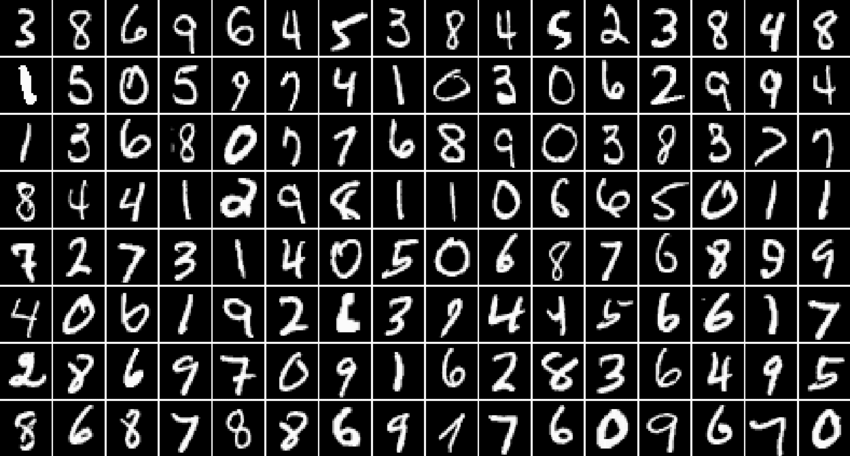
<center>Here are 128 out of the 70,000 images in the database!</center>



### What is the MNIST Classifier Model used in this notebook❓ ###
The model you will be exploring in this notebook is called the MNIST Classifier Model. This model is a type of Convolutional Neural Network (CNN) model which is good for identifying features and patterns in images. The MNIST Classifier Model has already been trained on the MNIST dataset for you. 

Note that during training, this CNN model has to learn to recognize different patterns in the images by adjusting the weights and biases of its neurons. It uses a labeled dataset, where each image in the dataset knows its correct digit, to iteratively improve its predictions. In simpler terms, this model uses the correct answers you give it to predict more accurate answers for images you give it in the future!


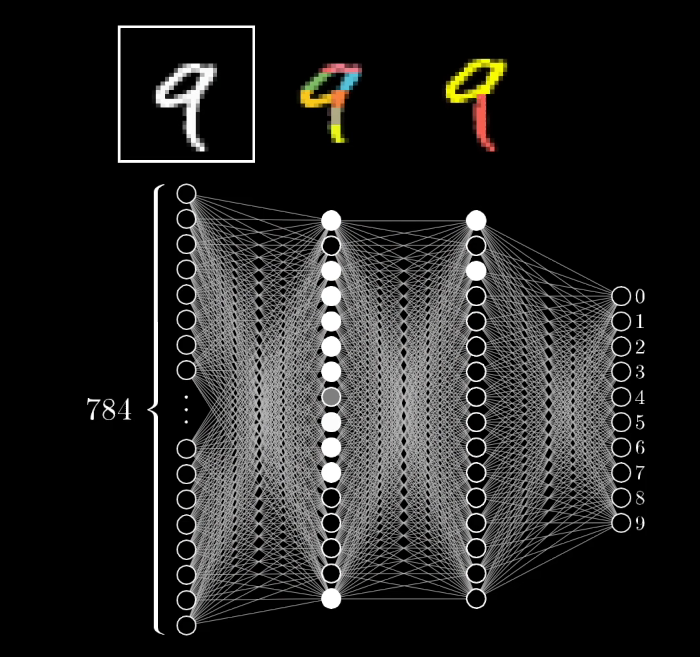
<center>This is a great visual example of what the MNIST Classifier Model is! There are different layers that</center>
    <center>recognize different patterns of the image you input into it!</center>


## 😎 Let's get started! 😎 ##
----
### 🧐 Setup 🧐 ###
Connect these peripherals to your board!
* USB Camera

<img align ="left" src="img\logi_webcam.jpg"  width="150" height="150">

<br/><br/><br/><br/><br/><br/><br/><br/>

* PMOD Adapter
    * RGB LED Stick
    
    <img align ="left" src="img\pynq_grove_adapter.jpg"  width="150" height="150"> <img align ="center" src="img\rgb_led_bar.png"  width="150" height="150">
<br/><br/>

### Step 1: Load dpu.bit Overlay  ###
The board in front of you has a Field Programmable Gate Array (FPGA) on it that needs to be programmed before the board can be used. We apply designs called overlays that we can design however we want. For this and future notebooks, you will program the FPGA on your board with a pre-built dpu overlay called 🔥dpu.bit🔥.

In [ ]:
# this library is for downloading the overlay to the board
from pynq_dpu import DpuOverlay
# this line will be used later when we want to use the RGB LED Stick
from pynq_peripherals import PmodGroveAdapter
# downloading the overlay to the board
overlay = DpuOverlay("dpu.bit")

Next let's write some code to prepare the RGB LED stick!

In [ ]:
# initiate the PMOD adapter
adapter = PmodGroveAdapter(overlay.PMODA, G4='grove_led_stick')
# the 'G4' means that we are attaching the RGB LED stick to the G4 
# port on the PMOD Adapter

# define the device object
led_stick = adapter.G4
# this is so we can use the name led_stick when 
# we want to reference the peripheral later

# let's also clear the stick so we start from a fresh state
led_stick.clear()
# this is a good habit in case you
# plan on changing the colors later

### Step 2: Load the MNIST Classifier Model  ###
This line loads a model that has already been compiled for you! Remember this line in case you want to load future models onto your board! 😉

In [ ]:
overlay.load_model("dpu_mnist_classifier.xmodel")

### 📚 Step 3: Import Libraries 📚 ###
Let's import some libraries we will need later in this notebook as well. A library is a collection of pre-written code that provides you with different types of functionality so you don't have to write it yourself from scratch! We can thank other developers who shared these libraries for their time and effort!


In [ ]:
from time import time                                      # various time-related functions
import os                                                  # portable way of using operating system dependent functionality
import numpy as np                                         # contains multidimensional array and matrix data structures
import mnist                                               # functions to load dataset and labels 
import matplotlib.pyplot as plt                            # data visualization library for plots, graphs and charts
%matplotlib inline
from six.moves import urllib                               # imports a mixture of urllib, urllib2 and urlparse with Python2
import cv2                                                 # computer vision library for solving computer vision problems

# the mnist package requires some additional headers for URL requests
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Step 4: Load test data ### 
Let's load up some of the images from the MNIST dataset! Some models require specific types of images as input, and the MNIST classifier model is one of them! 

Did you notice how most of the images in the database have a black background with a white digit?
This means that the images will require some pre-processing. For the NMIST database, there are two pre-processing steps we need to do to the test images before we can use it: 
1. Normalize the elements to floating-point or decimal numbers ranging from 0 to 1
2. Convert each input to an array of 3 dimensions 

It's ok if there is something you don't understand! Please make sure to ask questions!

In [ ]:
# the test_images method contains about 10,000 images from the MNIST database!
raw_data = mnist.test_images()
print (raw_data.shape)

normalized_data = np.asarray(raw_data/255, dtype=np.float32)
print (normalized_data.shape)

test_data = np.expand_dims(normalized_data, axis=3)
print (test_data.shape)

test_label = mnist.test_labels()

print("Total number of test images: {}".format(test_data.shape[0]))
print("  Dimension of each picture: {}x{}".format(test_data.shape[1],
                                                  test_data.shape[2]))

In [ ]:
# You can also display different digits in the database! 
# Try changing the "505" in the next two lines to a 
# different number from 0-9999  
# make sure to rerun the cell when you change code!
plt.imshow(test_data[505,:,:,0], 'gray')
plt.title('Label: {}'.format(test_label[505]))
plt.axis('off')
plt.show()

### Step 5: More set up
The next few cells of code will be seen in a bit throughout future notebooks and help models store and process data. 

In [ ]:
# creates a runner instance that has a number of member functions to control 
# the execution and get the input and output tensors
dpu = overlay.runner

# get the input and output tensors
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

# define the required input and output shapes of the data being put into and received from the model
shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

# create a new array of given shape and type, without initializing entries
softmax = np.empty(outputSize)

In [ ]:
# create an empty array for output data with the correct shape (shapeOut) and type (float32)
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]

# create an empty array for input data with the correct shape (shapeIn) and type (float32)
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]

# create a variable to store the first element of the input_data
image = input_data[0]

In [ ]:
# We will also define a few functions to calculate softmax. 
# Softmax is an activation function that predicts a multinomial probability distribution. 
# So you can see the probabilities or how likely each output was. 
def calculate_softmax(data):
    result = np.exp(data)
    return result

### Step 6: Run DPU to make predictions ### 
We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

In [ ]:
# try changing the number of pictures to 2! 
# how about 5? 13? 
# make sure to rerun the cell when you change code!
num_pics  = 10

# format the pictures using matplotlib
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()

# iterate through num_pics amount of images in the database 
for i in range(num_pics):
    image[0,...] = test_data[i]
    
    # this is where the model is making its predictions
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # reshape the data in the output
    temp = [j.reshape(1, outputSize) for j in output_data]
    
    # use the softmax function we defined above to calculate the probabilities of each possible output
    softmax = calculate_softmax(temp[0][0])
    prediction = softmax.argmax()

    # display the image and its associated prediction
    ax[i].set_title('Prediction: {}'.format(prediction))
    ax[i].axis('off')
    ax[i].imshow(test_data[i,:,:,0], 'gray')

We can also evaluate on the entire test dataset.

In [ ]:
# define how many images there are in the database
total = test_data.shape[0]

# create an empty array with the same shape and type as the test_label array
predictions = np.empty_like(test_label)
print("Classifying {} digit pictures ...".format(total))

# this line will be so we can time how long our predictions take
start = time()

# iterate through all the images in the database 
for i in range(total):
    image[0,...] = test_data[i]
    
    # model is making its predictions
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # reshape the data in the output
    temp = [j.reshape(1, outputSize) for j in output_data]
    
    # use the softmax function we defined above to calculate the probabilities of each possible output
    softmax = calculate_softmax(temp[0][0])
    predictions[i] = softmax.argmax()

# keep track of end time
stop = time()

# sum up how often the model is correct to calculate accuracy later 
correct = np.sum(predictions==test_label)

# calculate the execution time by taking the latest time subtracted by earlier time
execution_time = stop-start

# print results!
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

#### 🤩WHOA! This output means that your model was able to classify almost 1 or 100% of the handwritten images correctly in a few seconds!🤩 #### 

----

## 🤔 How good is your handwriting? 🤔 ##

### Step 7: Using the USB Camera 📷
Next, we will connect the USB Camera and capture a few frames of your handwritten digits to see how accurately the model can classify your numbers! 

But let's add a twist! When we print out the prediction, let's also display the prediction on the RGB LED Stick in red! 

#### 🌈 Let's set the color of the RGB LED Stick 🌈 #### 
The RGB LED stick command 

`led_stick.set_pixel(index, rgb(red, green, blue))` 

has these parameters
* parameter 1: the index of led in Grove RGB LED Stick (number);   
* parameter 2: the color of led in Grove RGB LED Stick (RGB). 

The best way to represent this color is in the rgb(*red, green, blue*) format. RGB stands for <span style="color:red">*red*</span>, <span style="color:green">*green*</span>, and <span style="color:blue">*blue*</span>. You can set the value of each color as a number from 0-255, the greater the number means the more of that color you will have in your overall color. 

You can use the internet to look up the rgb values of some cool colors! 
Some cool colors to remember are:
* <span style="color:red">red (255, 0, 0)</span>
* <span style="color:orange">orange (255, 165, 0)</span>
* <span style="color:yellow">yellow (0, 255, 255)</span>
* <span style="color:green">green (0, 255, 0)</span>
* <span style="color:blue">blue (0, 0, 255)</span>
* <span style="color:purple">purple (255, 0, 255)</span>
* <span style="color:pink">pink (my favorite!) (255, 192, 203)</span>

In [ ]:
# this function takes your rgb values and converts it into one number
# to pass into the set_pixel function
def rgb(r, g, b):
    return int('0x{:02x}{:02x}{:02x}'.format(r, g, b), 16)

# try changing the rgb values to make some cool colors! 
led_stick.set_pixel(0, rgb(255, 0, 0))
led_stick.set_pixel(1, rgb(255, 35, 0))
led_stick.set_pixel(2, rgb(255, 87, 0))
led_stick.set_pixel(3, rgb(255, 140, 0))
led_stick.set_pixel(4, rgb(255, 193, 0))
led_stick.set_pixel(5, rgb(255, 246, 0))
led_stick.set_pixel(6, rgb(212, 255, 0))
led_stick.set_pixel(7, rgb(159, 255, 0))
led_stick.set_pixel(8, rgb(106, 255, 0))
led_stick.set_pixel(9, rgb(0, 255, 0))

# finally use the line below to actually display the colors
led_stick.show()

Here is the expected output of the led stick.
<img align ="center" src="img\rainbowled.jpg"  width="550" height="400">

In [ ]:
# let's make this a function that we can call 
# to make it easier to set the colors
def setRGBLedStick(numOfLeds, color):
    led_stick.clear()
    for led in range(numOfLeds):
        led_stick.set_pixel(led, color)
    led_stick.show()

In [ ]:
# try the function, here we are having all 10 leds light up
setRGBLedStick(10, rgb(150,0,150))

Here is the expected output of the led stick.
<img align ="center" src="img\pinkled.jpg"  width="550" height="400">

In [ ]:
# here are 0 leds lit up
setRGBLedStick(0, rgb(150,0,150))

Here is the expected output of the led stick.
<img align ="center" src="img\offled.jpg"  width="550" height="400">

#### 📸Taking a picture📸 #### 

In [ ]:
# initialize the camera
camera = cv2.VideoCapture(-1)

In [ ]:
# grab a single frame of video
ret, frame = camera.read()
# show camera frame
plt.imshow(frame)
# try changing the title to your name!
plt.title('Hello!')
# display the frame to the notebook
plt.show()

In [ ]:
# close camera
camera.release()

Let's do some pre-processing to make your image a 28x28 pixel handwritten image to be fed into the model! Also, let's stick this in a preprocessing function for later use!

In [ ]:
def preprocess_img(frame):
    # resizes the image into a 28x28 pixel array
    img_resized = cv2.resize(frame, (28,28), interpolation=cv2.INTER_LINEAR)

    # use the cvtColor() function from the cv2 library to convert the frame to a grayscale image
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # let's help the model by doing some image thresholding
    # if the pixels in the image are above a certain threshold, then they will just become white
    # otherwise, the pixel will just be black, this will enable us to send only 
    # black and white images into the model
    ret,img_thresh = cv2.threshold(img_gray,120,255,cv2.THRESH_BINARY_INV)

    # preview resized and colored image
    plt.imshow(img_thresh, 'gray')
    
    # pre-process it with the two steps mentioned in step 4
    img_thresh = img_thresh[np.newaxis, :, :]

    normalized_data = np.asarray(img_thresh/255, dtype=np.float32)
    test_data = np.expand_dims(normalized_data, axis=3)
    
    return (test_data)

In [ ]:
preprocessed_img = preprocess_img(frame)

Let's run our image through the model! 

In [ ]:
image[0,...] = preprocessed_img
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)
temp = [j.reshape(1, outputSize) for j in output_data]
softmax = calculate_softmax(temp[0][0])
prediction = softmax.argmax()

# this prints out what the model thinks is the correct digit
print ("Prediction: " + str(prediction))
setRGBLedStick(prediction, rgb(150,0,150))

# this prints the probabilities that the model attributes to each digit!
# each value represents the digits 0-9, the greatest value is the digit the
# model is the most confident in
print (softmax)
plt.imshow(preprocessed_img[0,:,:,0], 'gray')

#### 🎥 Taking a video 🎥 #### 

In [ ]:
# for a running webcam video, let's import these libraries
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [ ]:
# this code below will set up a stop button that we can click to stop the camera feed
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',                         
    icon='square' # (FontAwesome names without the `fa-` prefix)
)

In [ ]:
# we can create this function to capture the webcam video,
# preprocess each frame, and set each frame through the model
def view(button):
    # let's initialize the camera
    cap = cv2.VideoCapture(-1)
    display_handle=display(None, display_id=True)
    
    # this loop will run until you press the red stop button
    while True:
        # read in a frame from the camera 
        _, frame = cap.read()
        _, framee = cv2.imencode('.jpeg', frame)
        # update the frame to your display on the notebook
        display_handle.update(Image(data=framee.tobytes()))
        
        # preprocess and send the frame through the model
        image[0,...] = preprocess_img(frame)
        job_id = dpu.execute_async(input_data, output_data)
        dpu.wait(job_id)
        temp = [j.reshape(1, outputSize) for j in output_data]
        softmax = calculate_softmax(temp[0][0])
        prediction = softmax.argmax()
        
        # print the prediction
        print ("Prediction: " + str(prediction), end="\r")
        # light up the led stick according to the prediction
        setRGBLedStick(prediction, rgb(150,0,150))
        
        # this if-statement stops the loop when a stop-button is pressed
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)
            setRGBLedStick(0, rgb(150,0,150))
            break

In [ ]:
# creates a display that will run until the stop button is pressed
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

### 🧼 Step 7: Clean up 🧼 ### 
We can let Python garbage-collect the unused objects and stuff from all this code we just ran. This will make sure we can run other notebooks without any issues! 

In [ ]:
del overlay
del dpu

## Summary ##
Let's summarize, in this notebook we
* understood what the MNIST database is,
* learned how to use the MNIST Classifier Model, 
* programmed the grove <span style="color:red">R</span><span style="color:green">G</span><span style="color:blue">B</span> LED stick, and
* explored how we can use the MNIST database and model in different ways! 

### ✨ Bonus Challenges! ✨ ###
Here are some optional challenges for you to work through! 
* Display the prediction of the model in different colors on the RGB LED stick so it is not all one color
    * hint: you may have to change the `setRGBLedStick()` function above 
    
    
* Take a look at the softmax function, what does it do? If you are not quite sure, ask one of us! 
    * Is there a way to differentiate how confident the model is in its predictions using this function?
    * Try changing the color of the RGB LED bar to correspond to how confident the model is in its prediction. 